In [2]:
import pandas as pd

In [3]:
df = pd.read_csv("../data/marketing_AB.csv")

# EDA

In [4]:
def basic_eda_summary(df):
    """
    Prints a basic exploratory data analysis summary of a DataFrame.
    Includes shape, column info, missing values, data types, and simple statistics.
    Visualization is excluded by design.
    """

    print("=" * 50)
    print("BASIC EDA SUMMARY")
    print("=" * 50)

    # Shape of the DataFrame
    print("\n[1] Shape of the DataFrame:")
    print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}")

    # Column names
    print("\n[2] Column Names:")
    print(df.columns.tolist())

    # Data types and non-null counts
    print("\n[3] Data Types and Non-Null Counts:")
    print(df.info(memory_usage=False, verbose=True))

    # Missing values per column
    print("\n[4] Missing Values (per column):")
    missing = df.isna().sum()
    print(missing[missing > 0] if missing.any() else "No missing values.")

    # Number of unique values per column
    print("\n[5] Number of Unique Values per Column:")
    print(df.nunique())

    # Basic statistics for numeric columns
    print("\n[6] Summary Statistics (numeric columns):")
    print(df.describe())

    print("\nBasic EDA summary complete.")

def detect_categorical_candidates(df, threshold_ratio=0.05, max_display_values=5):
    """
    Detects likely categorical features in a DataFrame, including:
    - object dtype with low cardinality
    - numeric columns with small unique value count relative to total rows
    """

    print("Categorical Feature Candidates\n" + "=" * 40)

    total_rows = len(df)

    for col in df.columns:
        unique_vals = df[col].nunique(dropna=False)
        dtype = df[col].dtype

        # Heuristic 1: object or category dtype with low cardinality
        if dtype == 'object' or dtype.name == 'category':
            print(f"- {col} [type: {dtype}, {unique_vals} unique] — likely categorical (textual)")
            sample = df[col].dropna().unique()[:max_display_values]
            print(f"  sample values: {sample} ...\n")

        # Heuristic 2: numeric column with low cardinality
        elif unique_vals < total_rows * threshold_ratio:
            print(f"- {col} [type: {dtype}, {unique_vals} unique] — possibly categorical (numeric)")
            sample = df[col].dropna().unique()[:max_display_values]
            print(f"  sample values: {sample} ...\n")

    print("Categorical detection complete.\n")


In [5]:
df.head()

,Unnamed: 0,user id,test group,converted,total ads,most ads day,most ads hour
0,0,1069124,ad,False,130,Monday,20
1,1,1119715,ad,False,93,Tuesday,22
2,2,1144181,ad,False,21,Tuesday,18
3,3,1435133,ad,False,355,Tuesday,10
4,4,1015700,ad,False,276,Friday,14


In [6]:
detect_categorical_candidates(df,threshold_ratio=0.001)
basic_eda_summary(df)

Categorical Feature Candidates
- test group [type: object, 2 unique] — likely categorical (textual)
  sample values: ['ad' 'psa'] ...

- converted [type: bool, 2 unique] — possibly categorical (numeric)
  sample values: [False  True] ...

- most ads day [type: object, 7 unique] — likely categorical (textual)
  sample values: ['Monday' 'Tuesday' 'Friday' 'Saturday' 'Wednesday'] ...

- most ads hour [type: int64, 24 unique] — possibly categorical (numeric)
  sample values: [20 22 18 10 14] ...

Categorical detection complete.

BASIC EDA SUMMARY

[1] Shape of the DataFrame:
Rows: 588101, Columns: 7

[2] Column Names:
['Unnamed: 0', 'user id', 'test group', 'converted', 'total ads', 'most ads day', 'most ads hour']

[3] Data Types and Non-Null Counts:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 588101 entries, 0 to 588100
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Unnamed: 0     588101 non-null  int64 


In [7]:
df = df.drop(columns=['Unnamed: 0'])
df = df.drop(columns=['user id'])

group_ad = df[df['test group'] == 'ad']['converted'].astype(float).dropna()
group_psa = df[df['test group'] == 'psa']['converted'].astype(float).dropna()

In [8]:
df['converted'].mean()

np.float64(0.02523886203220195)

In [9]:
df.groupby('test group')['converted'].mean()

test group
ad     0.025547
psa    0.017854
Name: converted, dtype: float64

<Axes: xlabel='test group', ylabel='converted'>

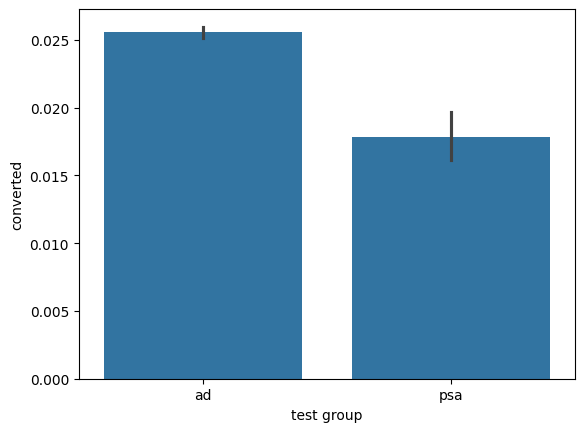

In [10]:
import seaborn as sns
sns.barplot(data=df, x='test group', y='converted')


# Welch's t-test

In [9]:
from scipy.stats import ttest_ind

group_ad = df[df['test group'] == 'ad']['converted'].astype(float)
group_psa = df[df['test group'] == 'psa']['converted'].astype(float)

# Welch's t-test（equal_var=False）
t_stat, p_value = ttest_ind(group_ad, group_psa, equal_var=False)
print(f"Welch's t-test: t = {t_stat:.4f}, p = {p_value:.4f}")

# 有意性の判断（通常α = 0.05）
if p_value < 0.05:
    print("→ 統計的に有意な差があります（広告の効果に差がある可能性）")
else:
    print("→ 有意な差は確認されません（広告の効果は明確でない）")


Welch's t-test: t = 8.6572, p = 0.0000
→ 統計的に有意な差があります（広告の効果に差がある可能性）


In [10]:
import numpy as np

group_ad = df[df['test group'] == 'ad']['converted'].astype(float)
group_psa = df[df['test group'] == 'psa']['converted'].astype(float)

# 平均・標準偏差の計算
mean_diff = group_ad.mean() - group_psa.mean()
std1 = group_ad.std()
std2 = group_psa.std()

# Pooled 標準偏差（Welch's t用：等分散でない想定）
pooled_std = np.sqrt((std1**2 + std2**2) / 2)

# Cohen's d
cohens_d = mean_diff / pooled_std
print(f"Cohen's d: {cohens_d:.4f}")

Cohen's d: 0.0528


# Bayes

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta

# データ集計
ad_successes = df[(df['test group'] == 'ad')]['converted'].sum()
ad_trials = df[df['test group'] == 'ad'].shape[0]

psa_successes = df[(df['test group'] == 'psa')]['converted'].sum()
psa_trials = df[df['test group'] == 'psa'].shape[0]

# ベータ分布の事前分布（非情報的 prior: alpha=1, beta=1）
ad_alpha, ad_beta = ad_successes + 1, ad_trials - ad_successes + 1
psa_alpha, psa_beta = psa_successes + 1, psa_trials - psa_successes + 1

# サンプルを描画（モンテカルロ）
samples = 100_000
ad_samples = np.random.beta(ad_alpha, ad_beta, samples)
psa_samples = np.random.beta(psa_alpha, psa_beta, samples)

# 勝率（adの方が高い確率）
prob_ad_better = (ad_samples > psa_samples).mean()

# 結果表示
print(f"広告グループのCVRがPSAグループより高い確率: {prob_ad_better:.4f}")


広告グループのCVRがPSAグループより高い確率: 1.0000


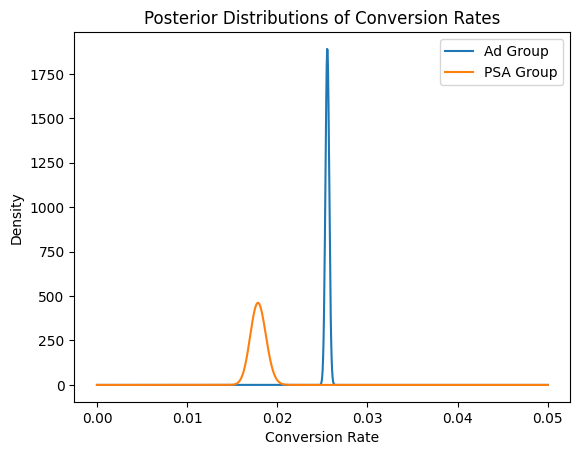

In [12]:
x = np.linspace(0, 0.05, 1000)
plt.plot(x, beta.pdf(x, ad_alpha, ad_beta), label='Ad Group')
plt.plot(x, beta.pdf(x, psa_alpha, psa_beta), label='PSA Group')
plt.xlabel('Conversion Rate')
plt.ylabel('Density')
plt.title('Posterior Distributions of Conversion Rates')
plt.legend()
plt.show()


# More

In [13]:
# パーセンタイル境界を計算
q33 = df['total ads'].quantile(0.33)
q66 = df['total ads'].quantile(0.66)

# カテゴリを追加（ラベルは medium にしてます）
def make_classify_ads(x):
    if x <= q33:
        return 'light'
    elif x <= q66:
        return 'medium'
    else:
        return 'heavy'

df['user_segment'] = df['total ads'].apply(make_classify_ads)


segment_counts_df = df['user_segment'].value_counts().reset_index()
segment_counts_df.columns = ['user_segment', 'count']

conversion_rate_df = df.groupby(['user_segment', 'test group'])['converted'].mean().reset_index()
conversion_rate_df.columns = ['user_segment', 'test_group', 'conversion_rate']

display(segment_counts_df)
display(conversion_rate_df)

,user_segment,count
0,light,201232
1,heavy,199842
2,medium,187027


,user_segment,test_group,conversion_rate
0,heavy,ad,0.065577
1,heavy,psa,0.042109
2,light,ad,0.002579
3,light,psa,0.003033
4,medium,ad,0.007496
5,medium,psa,0.007972


In [14]:
df['day_type'] = df['most ads day'].apply(lambda x: 'weekend' if x in ['Saturday', 'Sunday'] else 'weekday')
# df.groupby(['day_type', 'test group'])['converted'].mean()

# 1. day_type × test group の件数（表形式に）
daytype_counts_df = df.groupby(['day_type', 'test group'])['converted'].count().reset_index()
daytype_counts_df.columns = ['day_type', 'test_group', 'count']

# 2. day_type × test group のコンバージョン率（表形式に）
daytype_conversion_df = df.groupby(['day_type', 'test group'])['converted'].mean().reset_index()
daytype_conversion_df.columns = ['day_type', 'test_group', 'conversion_rate']

# 表示
display(daytype_counts_df)
display(daytype_conversion_df)

,day_type,test_group,count
0,weekday,ad,403443
1,weekday,psa,17607
2,weekend,ad,161134
3,weekend,psa,5917


,day_type,test_group,conversion_rate
0,weekday,ad,0.026564
1,weekday,psa,0.018004
2,weekend,ad,0.022999
3,weekend,psa,0.017407


In [15]:
def make_classify_hour(x):
    if 5 <= x < 12:
        return 'morning'
    elif 12 <= x < 18:
        return 'afternoon'
    else:
        return 'evening'

df['time_segment'] = df['most ads hour'].apply(make_classify_hour)
# df.groupby(['time_segment', 'test group'])['converted'].mean()

# 1. time_segment × test group の件数（表形式に）
timesegment_counts_df = df.groupby(['time_segment', 'test group'])['converted'].count().reset_index()
timesegment_counts_df.columns = ['time_segment', 'test_group', 'count']

# 2. time_segment × test group のコンバージョン率（表形式に）
timesegment_conversion_df = df.groupby(['time_segment', 'test group'])['converted'].mean().reset_index()
timesegment_conversion_df.columns = ['time_segment', 'test_group', 'conversion_rate']

# 表示
display(timesegment_counts_df)
display(timesegment_conversion_df)

,time_segment,test_group,count
0,afternoon,ad,246925
1,afternoon,psa,10914
2,evening,ad,180384
3,evening,psa,6860
4,morning,ad,137268
5,morning,psa,5750


,time_segment,test_group,conversion_rate
0,afternoon,ad,0.027668
1,afternoon,psa,0.020158
2,evening,ad,0.025978
3,evening,psa,0.018659
4,morning,ad,0.021163
5,morning,psa,0.012522


In [16]:
df.head()

,test group,converted,total ads,most ads day,most ads hour,user_segment,day_type,time_segment
0,ad,False,130,Monday,20,heavy,weekday,evening
1,ad,False,93,Tuesday,22,heavy,weekday,evening
2,ad,False,21,Tuesday,18,heavy,weekday,evening
3,ad,False,355,Tuesday,10,heavy,weekday,morning
4,ad,False,276,Friday,14,heavy,weekday,afternoon
